In [ ]:
import datetime
from sklearn import preprocessing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from IPython.display import Image  
from sklearn.model_selection import cross_val_score
import pydotplus as pdp
import math 

dff = pd.read_csv("latestdata.csv", low_memory = False)

In [ ]:
clean = {"date_confirmation": {'25.02.2020 - 03.03.2020': '27.02.2020',
                               '07.03.2020 - 10.03.2020': '09.03.2020', 
                               '06.03.2020 - 10.03.2020': '08.03.2020',
                               '12.03.2020-14.03.2020': '13.03.2020', 
                               '18.03.2020-19.03.2020': '18.03.2020', 
                               '07.03.2020 - 09.03.2020': '08.03.2020',
                               '10.03.2020 - 11.03.2020': '10.03.2020', 
                               '12.03.2020 - 13.03.2020': '12-03-2020',
                               '05.03.2020-06.03.2020': '05.03.2020', 
                               '07.03.2020-09.03.2020': '08.03.2020',
                               '10.03.2020-13.03.2020': '11.03.2020', 
                               '06.03.2020 - 08.03.2020': '07.03.2020',
                               '06.03.2020-13.03.2020': '09.03.2020', 
                               '05.03.2020 - 18.03.2020': '12.03.2020',
                               '07.03.2020 - 16.03.2020': '12.03.2020', 
                               '07.03.2020 - 13.03.2020': '10.03.2020',
                               '14.03.2020 - 15.03.2020': '14.03.2020', 
                               '10.03.2020 - 12.03.2020': '11.03.2020',
                               '06.03.2020 - 09.03.2020': '08.03.2020', 
                               '06.03.2020 - 12.03.2020': '09.03.2020',
                               '14.03.2020 - 16.03.2020': '15.03.2020',
                               '25.02.2020 - 26.02.2020': '25.02.2020'}}
dff.replace(clean, inplace=True)

dff.date_confirmation.unique()
dff['date_confirmation'] = pd.to_datetime(dff['date_confirmation'])
dff['days_from_start'] = dff['date_confirmation'] - np.datetime64('2020-01-01')
dff['days_from_start']= dff['days_from_start'].dt.days

df = dff.dropna()


cleaner = {"sex": {"male": 1, "female": 0},
           "chronic_disease_binary": {False: 0, True: 1},
          "age": {"20-29": 25, "35-59": 47, "15-34": 24, "60-79": 70, "80-89": 85, "50-59": 55, "15-88": 52,"60-69": 65}}
df.replace(cleaner, inplace=True)

df[pd.to_numeric(df['age'], errors='coerce').notnull()]
df = df[df.applymap(np.isreal).any(1)]
df.applymap(lambda x: isinstance(x, (int, float)))
data_columns = ['age']
df = (df.drop(data_columns, axis=1)
         .join(df[data_columns].apply(pd.to_numeric, errors='coerce')))

df = df[df[data_columns].notnull().all(axis=1)]

cleaner2 = {"outcome": {"Hospitalized": 0, "recovered": 0, "died": 1, 
                        "Deceased": 1, "discharge": 0, "Recovered": 0,
                        "stable condition": 0, "discharged": 0, 
                        "stable": 0, "death": 1, "Under treatment": 1, 
                        "Dead": 1, "Died": 1, "dead": 1, "Death": 1,
                        "released from quarantine": 0, 
                        "treated in an intensive care unit (14.02.2020)}}": 1,
                        "not hospitalized": 0, "Discharged": 0, "critical condition": 1,
                        "Receiving Treatment": 0, "severe illness": 1, "unstable": 1}}
df.replace(cleaner2, inplace=True)

cleaner3 = {"outcome": {"Alive":0, "Stable":0, "treated in an intensive care unit (14.02.2020)": 0}}
df.replace(cleaner3, inplace=True)
df = df.reset_index(drop=True)

df['hospital_bed_density'] = df['country']
df['pol_parity'] = df['country']
df['dem_ind'] = df['country']
df['female_lead'] = df['country']
df['happy_index'] = df['country']

w = pd.read_csv('women.csv')
w = w.rename(columns={"Country name": "country", "Political parity score": "pol_parity", "Woman Leader?": "female_lead"})
keys = []
values = []
values1 = []
for x in range(len(w)):
    keys.append(w['country'][x])
    values.append(w['pol_parity'][x])
    values1.append(w['female_lead'][x])
    
h = pd.read_csv('happy.csv')
keys3 = []
values_h = []
for x in range(len(h)):
    keys3.append(h['Country or region'][x])
    values_h.append(h['Score'][x])
    
    
d = pd.read_csv('demind.csv')
keys4 = []
values4 = []
for x in range(len(d)):
    keys4.append(d['country'][x])
    values4.append(d['dem_ind'][x])
    
hbd = pd.read_csv('hbd.csv')
key = []
value = []
for x in range(len(hbd)):
    key.append(hbd['country'][x])
    value.append(hbd['hbd'][x])
    
demin = dict(zip(keys4,values4))    
demin.update({'San Marino': 6.53, 'United Arab Emirates': 2.76, 'Bahamas': 4.36})
polpar = dict(zip(keys,values))
flb = dict(zip(keys, values1))
h = dict(zip(keys3, values_h))
hbd = dict(zip(key,value))

cleaner4 = {'hospital_bed_density': hbd,
            'pol_parity': polpar,
            'female_lead': flb,
            'dem_ind': demin,
            'happy_index': h}
df.replace(cleaner4, inplace=True)
l = ['Eswatini', 'Angola', 'Cabo Verde', 'Cuba', 'San Marino', 'Bahamas']
for x in l:
    df = df[df.country != x]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6666: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


In [ ]:
df = df.drop(['country', 'date_confirmation'], axis = 1).reset_index()
for x in range(len())

df.happy_index = float(df.happy_index)

TypeError: cannot convert the series to <class 'float'>

In [ ]:
df.dtypes

In [ ]:
df
train, test, validate = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print(train.shape, test.shape, validate.shape)
y_train = train['outcome']
x_train = train.drop(['outcome'], axis=1)
y_test = test['outcome']
x_test = test.drop(['outcome'], axis=1)
y_validate = validate['outcome']
x_validate = validate.drop(['outcome'], axis=1)

print(y_test.mean())
print(y_train.mean())
print(y_validate.mean())




(17996, 13) (5999, 13) (5999, 13)
0.022337056176029338
0.020393420760168927
0.022503750625104183


In [ ]:
def dt(x):
    tree_model = tree.DecisionTreeClassifier(criterion="entropy", max_depth=x) 
    tree_model = tree_model.fit(x_train, y_train)
    tree_model.score(x_train, y_train)


    predicted = pd.DataFrame(tree_model.predict(x_test))
    probs = pd.DataFrame(tree_model.predict_proba(x_test))


    tree_accuracy = metrics.accuracy_score(y_test, predicted)     
    tree_roc_auc = metrics.roc_auc_score(y_test, probs[1])       
    tree_confus_matrix = metrics.confusion_matrix(y_test, predicted) 
    tree_classification_report = metrics.classification_report(y_test, predicted)
    tree_precision = metrics.precision_score(y_test, predicted, pos_label=1)
    tree_recall = metrics.recall_score(y_test, predicted, pos_label=1)
    tree_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

    tree_cv_scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=x), x_validate, y_validate, scoring='precision', cv=10)
    tree_cv_mean = np.mean(tree_cv_scores)

    dot_data = tree.export_graphviz(tree_model, out_file=None, 
                         feature_names=x_test.columns.tolist(),
                         class_names=['Recover', 'Death'],
                         filled=True, rounded=True,  
                         special_characters=True)  

    graph = pdp.graph_from_dot_data(dot_data)
    graph.write_png(str(x) + "decision_tree.png")
    print("Depth: " + str(x))
    print(tree_cv_mean)
    
for x in range(1,10):
    dt(x)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetr

Depth: 1
0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Depth: 2
0.8166666666666667


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Depth: 3
0.8416666666666666
Depth: 4
0.7472222222222221
Depth: 5
0.7453463203463203
Depth: 6
0.6483333333333333
Depth: 7
0.6311904761904762
Depth: 8
0.6415445665445666
Depth: 9
0.5967478354978354


In [ ]:
x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=df.columns)

train, test, validate = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print(train.shape, test.shape, validate.shape)
y_train = train['outcome']
x_train = train.drop(['outcome'], axis=1)
y_test = test['outcome']
x_test = test.drop(['outcome'], axis=1)
y_validate = validate['outcome']
x_validate = validate.drop(['outcome'], axis=1)
print(y_test.mean())
print(y_train.mean())
print(y_validate.mean())

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
df.country.value_counts()

India                       28425
Philippines                  1055
Singapore                     118
Ethiopia                      103
China                         101
Vietnam                        32
South Korea                    26
United States                  24
Australia                      24
Japan                          14
Ghana                           9
Romania                         8
Canada                          6
Malaysia                        6
France                          6
Gabon                           5
Togo                            5
Brazil                          4
Mozambique                      4
Italy                           4
Tanzania                        3
Switzerland                     2
Sudan                           2
Nepal                           2
Cameroon                        1
Gambia                          1
Germany                         1
Central African Republic        1
Burkina Faso                    1
Guinea        

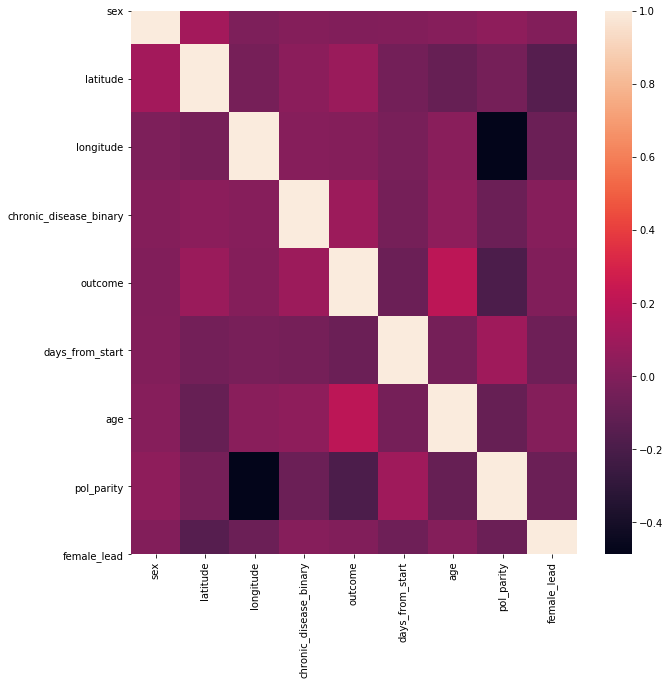

In [ ]:
correlation = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1)

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), 
                     rf.feature_importances_), x_train), reverse=True))

TypeError: invalid type promotion

In [ ]:
logit_model = LogisticRegression()
logit_model = logit_model.fit(x_train, y_train)
logit_model.score(x_train, y_train)

predicted = pd.DataFrame(logit_model.predict(x_test))
probs = pd.DataFrame(logit_model.predict_proba(x_test))

logit_accuracy = metrics.accuracy_score(y_test, predicted)    
logit_precision = metrics.precision_score(y_test, predicted, pos_label=1)
logit_recall = metrics.recall_score(y_test, predicted, pos_label=1)
logit_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

logit_cv_scores = cross_val_score(LogisticRegression(), x_validate, y_validate, scoring='precision', cv=10)
logit_cv_mean = np.mean(logit_cv_scores)

TypeError: invalid type promotion

In [ ]:
rf = RandomForestClassifier()
rf_model = rf.fit(x_train, y_train)
rf_model.score(x_train, y_train)

predicted = pd.DataFrame(rf_model.predict(x_test))
probs = pd.DataFrame(rf_model.predict_proba(x_test))

rf_accuracy = metrics.accuracy_score(y_test, predicted)     
rf_roc_auc = metrics.roc_auc_score(y_test, probs[1])       
rf_confus_matrix = metrics.confusion_matrix(y_test, predicted) 
rf_classification_report = metrics.classification_report(y_test, predicted)
rf_precision = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

rf_cv_scores = cross_val_score(RandomForestClassifier(), x_validate, y_validate, scoring='precision', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

In [ ]:
models = pd.DataFrame({
  'Model': ['Logistic', 'd.Tree', 'r.f.'],
  'Accuracy' : [logit_accuracy, tree_accuracy, rf_accuracy],
  'Precision': [logit_precision, tree_precision, rf_precision],
  'recall' : [logit_recall, tree_recall, rf_recall],
  'F1' : [logit_f1, tree_f1, rf_f1],
  'cv_precision' : [logit_cv_mean, tree_cv_mean, rf_cv_mean]
})
models.sort_values(by='F1', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_precision
1,d.Tree,0.969042,0.686567,0.351145,0.464646,0.517658
2,r.f.,0.962325,0.528736,0.343284,0.416290,0.626753
0,Logistic,0.964515,0.658228,0.194030,0.299712,0.701905


In [ ]:
print(logit_model.coef_)

[[ 6.63886778 -1.07149736  2.95314302 -2.3257363   2.21693035 -3.01018278
  -3.22812591  0.00859721 -1.6571196   4.6293554 ]]


In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(10, input_dim=10, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# evaluate baseline model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, x_test, y_test, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Instructions for updating:
Use tf.cast instead.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

Standardized: 96.69% (0.53%)


In [ ]:
df_country = df_country.replace({"outcome": {"Hospitalized": 0, "recovered": 0, "died": 1, 
                                "Deceased": 1, "discharge": 0, "Recovered": 0,
                        "stable condition": 0, "discharged": 0, 
                        "stable": 0, "death": 1, "Under treatment": 1, 
                        "Dead": 1, "Died": 1, "dead": 1, "Death": 1,
                        "released from quarantine": 0, 
                        "treated in an intensive care unit (14.02.2020)}}": 1,
                        "not hospitalized": 0, "Discharged": 0, "critical condition": 1,
                        "Receiving Treatment": 0, "severe illness": 1, "unstable": 1,
                        "https://www.mspbs.gov.py/covid-19.php": 1, "Migrated_Other": 1,
                        "Migrated": 1, "Discharged from hospital": 0, "treated in an intensive care unit (14.02.2020)": 1,
                        "severe": 1, "recovering at home 03.03.2020": 0, "Symptoms only improved with cough. Currently hospitalized for follow-up.": 1,
                        "critical condition, intubated as of 14.02.2020": 1, "Critical condition": 1}})
df_country['outcome'].value_counts()

train, test, validate = np.split(df_country.sample(frac=1), [int(.6*len(df_country)), int(.8*len(df_country))])
print(train.shape, test.shape, validate.shape)
y_train = train['outcome']
x_train = train.drop(['outcome'], axis=1)
y_test = test['outcome']
x_test = test.drop(['outcome'], axis=1)
y_validate = validate['outcome']
x_validate = validate.drop(['outcome'], axis=1)
print(y_test.mean())
print(y_train.mean())
print(y_validate.mean())

KeyError: 'outcome'

In [ ]:
df_country['country'].value_counts()

India            301133
Philippines        4505
Ghana               378
China               257
Nigeria             257
Paraguay            126
Ethiopia            122
Singapore           118
United States        52
South Korea          26
Australia            24
Japan                18
Kenya                15
Algeria               9
France                7
Italy                 7
Canada                6
Brazil                4
Egypt                 4
Iran                  4
Burkina Faso          3
Germany               3
Switzerland           3
Spain                 2
Cuba                  1
Name: country, dtype: int64

In [ ]:
a = len(df_country)

for x in range(a):
    df_country = df_country.append([df_country.iloc[x]] * int(df_country['cases'][x]/100))

In [ ]:
df_country.to_csv('country_ds.csv')

In [ ]:
dfa = pd.read_csv('country_ds.csv')

In [ ]:
dfa

,Unnamed: 0,country,cases,deaths,mortality_rate,recovered,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption
0,0,Belgium,77869.0,9935.0,0.128,67934.0,55.80,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210
1,1,Peru,516296.0,25856.0,0.050,490440.0,15.91,47.7,6.60,0.0,0.960,1.274,0.854,0.455,0.083,0.027
2,2,United Kingdom,319232.0,46791.0,0.147,272441.0,24.60,42.9,8.52,0.0,1.333,1.538,0.996,0.450,0.348,0.278
3,3,Spain,342813.0,28617.0,0.083,314196.0,29.70,55.8,8.18,0.0,1.286,1.484,1.062,0.362,0.153,0.079
4,4,Italy,253438.0,35392.0,0.140,218046.0,31.40,37.0,7.52,0.0,1.294,1.488,1.039,0.231,0.158,0.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212810,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212811,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212812,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212813,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167


In [ ]:
df_country

,country,cases,deaths,mortality_rate,recovered,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption
0,Belgium,77869.0,9935.0,0.128,67934.0,55.80,42.6,7.64,1,1.356,1.504,0.986,0.473,0.16,0.21
1,Peru,516296.0,25856.0,0.050,490440.0,15.91,47.7,6.60,0,0.96,1.274,0.854,0.455,0.083,0.027
2,United Kingdom,319232.0,46791.0,0.147,272441.0,24.60,42.9,8.52,0,1.333,1.538,0.996,0.45,0.348,0.278
3,Spain,342813.0,28617.0,0.083,314196.0,29.70,55.8,8.18,0,1.286,1.484,1.062,0.362,0.153,0.079
4,Italy,253438.0,35392.0,0.140,218046.0,31.40,37,7.52,0,1.294,1.488,1.039,0.231,0.158,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Sri Lanka,2890.0,11.0,0.004,2879.0,41.50,15.7,6.27,0,0.949,1.265,0.831,0.47,0.244,0.047
133,Tanzania,509.0,21.0,0.041,488.0,7.00,30.6,5.16,0,0.476,0.885,0.499,0.417,0.276,0.147
134,Uganda,1434.0,13.0,0.009,1421.0,5.00,45.4,5.02,0,0.332,1.069,0.443,0.356,0.252,0.06
135,Vietnam,951.0,24.0,0.025,927.0,31.80,27.4,3.08,0,0.741,1.346,0.851,0.543,0.147,0.073


In [ ]:
counter = 0

for x in range(a): 
    for y in range(len(df_country.loc[x])):
        for 
    counter += len(df_country.loc[x])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
dfa.drop(['Unnamed: 0'], axis = 1)

,country,cases,deaths,mortality_rate,recovered,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption
0,Belgium,77869.0,9935.0,0.128,67934.0,55.80,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210
1,Peru,516296.0,25856.0,0.050,490440.0,15.91,47.7,6.60,0.0,0.960,1.274,0.854,0.455,0.083,0.027
2,United Kingdom,319232.0,46791.0,0.147,272441.0,24.60,42.9,8.52,0.0,1.333,1.538,0.996,0.450,0.348,0.278
3,Spain,342813.0,28617.0,0.083,314196.0,29.70,55.8,8.18,0.0,1.286,1.484,1.062,0.362,0.153,0.079
4,Italy,253438.0,35392.0,0.140,218046.0,31.40,37.0,7.52,0.0,1.294,1.488,1.039,0.231,0.158,0.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212810,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212811,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212812,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212813,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167


In [ ]:
l = list(dfa.country.unique())
len(l)

139

In [ ]:
for x in range(len(l)):
    dfa.drop([x])

KeyboardInterrupt: 

In [ ]:
dfa = dfa.iloc[139:]

In [ ]:
dfa = dfa.reset_index()

In [ ]:
dfa.drop(['index', 'Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
dfa['outcome'] = 0

In [ ]:
dfaa = dfa.drop_duplicates()
dfa

,Unnamed: 0,country,cases,deaths,mortality_rate,recovered,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption
0,0,Belgium,77869.0,9935.0,0.128,67934.0,55.80,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210
1,1,Peru,516296.0,25856.0,0.050,490440.0,15.91,47.7,6.60,0.0,0.960,1.274,0.854,0.455,0.083,0.027
2,2,United Kingdom,319232.0,46791.0,0.147,272441.0,24.60,42.9,8.52,0.0,1.333,1.538,0.996,0.450,0.348,0.278
3,3,Spain,342813.0,28617.0,0.083,314196.0,29.70,55.8,8.18,0.0,1.286,1.484,1.062,0.362,0.153,0.079
4,4,Italy,253438.0,35392.0,0.140,218046.0,31.40,37.0,7.52,0.0,1.294,1.488,1.039,0.231,0.158,0.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212810,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212811,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212812,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212813,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167


In [ ]:
dfaa.reset_index(inplace = True)

In [ ]:
dfaa.drop(['index'], axis = 1, inplace = True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dfaa

,country,cases,deaths,mortality_rate,recovered,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption,outcome
0,Belgium,77869.0,9935.0,0.128,67934.0,55.80,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,0
1,Peru,516296.0,25856.0,0.050,490440.0,15.91,47.7,6.60,0.0,0.960,1.274,0.854,0.455,0.083,0.027,0
2,United Kingdom,319232.0,46791.0,0.147,272441.0,24.60,42.9,8.52,0.0,1.333,1.538,0.996,0.450,0.348,0.278,0
3,Spain,342813.0,28617.0,0.083,314196.0,29.70,55.8,8.18,0.0,1.286,1.484,1.062,0.362,0.153,0.079,0
4,Italy,253438.0,35392.0,0.140,218046.0,31.40,37.0,7.52,0.0,1.294,1.488,1.039,0.231,0.158,0.030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Uganda,1434.0,13.0,0.009,1421.0,5.00,45.4,5.02,0.0,0.332,1.069,0.443,0.356,0.252,0.060,0
135,Vietnam,951.0,24.0,0.025,927.0,31.80,27.4,3.08,0.0,0.741,1.346,0.851,0.543,0.147,0.073,0
136,Yemen,1858.0,528.0,0.284,1330.0,7.10,1.9,1.95,0.0,0.287,1.163,0.463,0.143,0.108,0.077,0
137,Syria,1593.0,60.0,0.038,1533.0,14.00,9.3,1.43,0.0,0.619,0.378,0.440,0.013,0.331,0.141,0


In [ ]:
dfaa

,country,cases,deaths,mortality_rate,recovered,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption,outcome
0,Belgium,77869.0,9935.0,0.128,67934.0,55.80,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,0
1,Peru,516296.0,25856.0,0.050,490440.0,15.91,47.7,6.60,0.0,0.960,1.274,0.854,0.455,0.083,0.027,0
2,United Kingdom,319232.0,46791.0,0.147,272441.0,24.60,42.9,8.52,0.0,1.333,1.538,0.996,0.450,0.348,0.278,0
3,Spain,342813.0,28617.0,0.083,314196.0,29.70,55.8,8.18,0.0,1.286,1.484,1.062,0.362,0.153,0.079,0
4,Italy,253438.0,35392.0,0.140,218046.0,31.40,37.0,7.52,0.0,1.294,1.488,1.039,0.231,0.158,0.030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Uganda,1434.0,13.0,0.009,1421.0,5.00,45.4,5.02,0.0,0.332,1.069,0.443,0.356,0.252,0.060,0
135,Vietnam,951.0,24.0,0.025,927.0,31.80,27.4,3.08,0.0,0.741,1.346,0.851,0.543,0.147,0.073,0
136,Yemen,1858.0,528.0,0.284,1330.0,7.10,1.9,1.95,0.0,0.287,1.163,0.463,0.143,0.108,0.077,0
137,Syria,1593.0,60.0,0.038,1533.0,14.00,9.3,1.43,0.0,0.619,0.378,0.440,0.013,0.331,0.141,0


In [ ]:
dfa

,country,cases,deaths,mortality_rate,recovered,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption,outcome
0,Belgium,77869.0,9935.0,0.128,67934.0,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,0
1,Belgium,77869.0,9935.0,0.128,67934.0,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,0
2,Belgium,77869.0,9935.0,0.128,67934.0,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,0
3,Belgium,77869.0,9935.0,0.128,67934.0,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,0
4,Belgium,77869.0,9935.0,0.128,67934.0,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212671,Gambia,1689.0,54.0,0.032,1635.0,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167,0
212672,Gambia,1689.0,54.0,0.032,1635.0,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167,0
212673,Gambia,1689.0,54.0,0.032,1635.0,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167,0
212674,Gambia,1689.0,54.0,0.032,1635.0,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167,0


In [ ]:
dfa['outcome'] = 0

In [ ]:
counter = 0
for y in range(len(dfa)-1):
    for x in range(counter, int(dfaa['deaths'][y]/100) + counter):
        dfa['outcome'][x] = 1
    counter += int(dfaa['cases'][y]/100)
    print(y)
    print(counter)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0
778
1
5940
2
9132
3
12560
4
15094
5
15936
6
19775
7
73386
8
106556
9
109085
10
114262
11
115068
12
115339
13
115977
14
116983
15
117974
16
122540
17
122954
18
123080
19
123379
20
124617
21
128027
22
128443
23
128822
24
128896
25
134732
26
135271
27
135770
28
136463
29
138188
30
138346
31
138969
32
139824
33
142715
34
142754
35
143510
36
145754
37
146218
38
155376
39
155534
40
158507
41
158801
42
159027
43
159258
44
159330
45
160252
46
162733
47
162876
48
163902
49
165050
50
165743
51
165767
52
165815
53
165892
54
166169
55
167132
56
167473
57
168033
58
168132
59
168153
60
169070
61
169134
62
169775
63
169973
64
195872
65
196247
66
196313
67
196694
68
196717
69
199597
70
199616
71
201195
72
201277
73
202651
74
205396
75
205473
76
205541
77
205582
78
205704
79
205717
80
205810
81
205888
82
206298
83
206310
84
206323
85
206336
86
206520
87
206752
88
206872
89
206963
90
207002
91
207086
92
207132
93
207141
94
207178
95
207192
96
207518
97
207816
98
207835
99
207886
100
207936
101
208486


KeyError: 139

In [ ]:
dfa.outcome.value_counts()

0    205195
1      7620
Name: outcome, dtype: int64

In [ ]:
df1 = dfa.drop(['country', 'cases', 'deaths', 'mortality_rate', 'recovered'], axis = 1)

In [ ]:
df1

0    205195
1      7620
Name: outcome, dtype: int64

In [ ]:
train5, test5, validate5 = np.split(df1.sample(frac=1), [int(.6*len(df1)), int(.8*len(df1))])
print(train5.shape, test5.shape, validate5.shape)
y_train5 = train5['outcome']
x_train5 = train5.drop(['outcome'], axis=1)
y_test5 = test5['outcome']
x_test5 = test5.drop(['outcome'], axis=1)
y_validate5 = validate5['outcome']
x_validate5 = validate5.drop(['outcome'], axis=1)

print(y_test5.mean())
print(y_train5.mean())
print(y_validate5.mean())

(127689, 11) (42563, 11) (42563, 11)
0.03599370345135446
0.035265371331908
0.03723891642976294


In [ ]:
def dt(x):
    tree_model = tree.DecisionTreeClassifier(criterion="entropy", max_depth=x) 
    tree_model = tree_model.fit(x_train5, y_train5)
    tree_model.score(x_train5, y_train5)


    predicted = pd.DataFrame(tree_model.predict(x_test5))
    probs = pd.DataFrame(tree_model.predict_proba(x_test5))


    tree_accuracy = metrics.accuracy_score(y_test5, predicted)     
    tree_roc_auc = metrics.roc_auc_score(y_test5, probs[1])       
    tree_confus_matrix = metrics.confusion_matrix(y_test5, predicted) 
    tree_classification_report = metrics.classification_report(y_test5, predicted)
    tree_precision = metrics.precision_score(y_test5, predicted, pos_label=1)
    tree_recall = metrics.recall_score(y_test5, predicted, pos_label=1)
    tree_f1 = metrics.f1_score(y_test5, predicted, pos_label=1)

    tree_cv_scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=x), x_test5, y_test5, scoring='precision', cv=10)
    tree_cv_mean = np.mean(tree_cv_scores)

    dot_data = tree.export_graphviz(tree_model, out_file=None, 
                         feature_names=x_test5.columns.tolist(),
                         class_names=['Recover', 'Death'],
                         filled=True, rounded=True,  
                         special_characters=True)  

    graph = pdp.graph_from_dot_data(dot_data)
    graph.write_png(str(x) + "decision_tree1.png")
    print("Depth: " + str(x))
    print(tree_cv_mean)
    
for x in range(1,10):
    dt(x)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetr

Depth: 1
0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

Depth: 2
0.19
Depth: 3
0.41158730158730156
Depth: 4
0.516031746031746
Depth: 5
0.516031746031746
Depth: 6
0.516031746031746
Depth: 7
0.516031746031746
Depth: 8
0.516031746031746
Depth: 9
0.5033333333333333


In [ ]:
y_train5.value_counts()

0    122980
1      4625
Name: outcome, dtype: int64

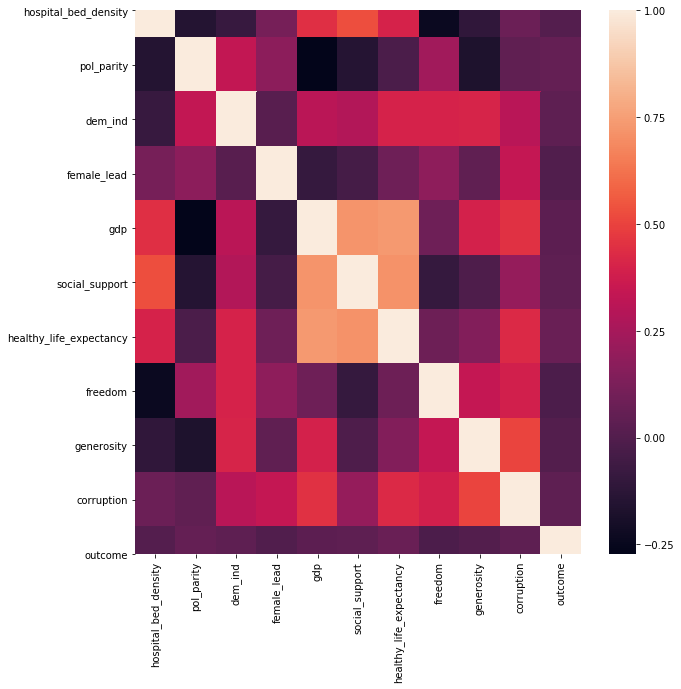

In [ ]:
correlation = df1.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1)

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train5, y_train5)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), 
                     rf.feature_importances_), x_train5), reverse=True))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.186, 'healthy_life_expectancy'), (0.1802, 'social_support'), (0.1555, 'pol_parity'), (0.1126, 'hospital_bed_density'), (0.1111, 'freedom'), (0.0819, 'gdp'), (0.0635, 'generosity'), (0.0534, 'corruption'), (0.0526, 'dem_ind'), (0.0031, 'female_lead')]


In [ ]:
df1

,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption,outcome
0,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,1
1,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,1
2,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,1
3,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,1
4,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210,1
...,...,...,...,...,...,...,...,...,...,...,...
212671,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167,0
212672,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167,0
212673,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167,0
212674,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167,0


In [ ]:
l = list(df1.columns)

In [ ]:
feats = ['hospital_bed_density','pol_parity','dem_ind','female_lead',
         'gdp','social_support','healthy_life_expectancy','freedom',
         'generosity','corruption']

In [ ]:
X = df1[feats]

In [ ]:
y = df1.outcome
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9640769242825572


In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feats,class_names=['living','death'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('country.png')
Image(graph.create_png())

ModuleNotFoundError: No module named 'sklearn.externals.six'

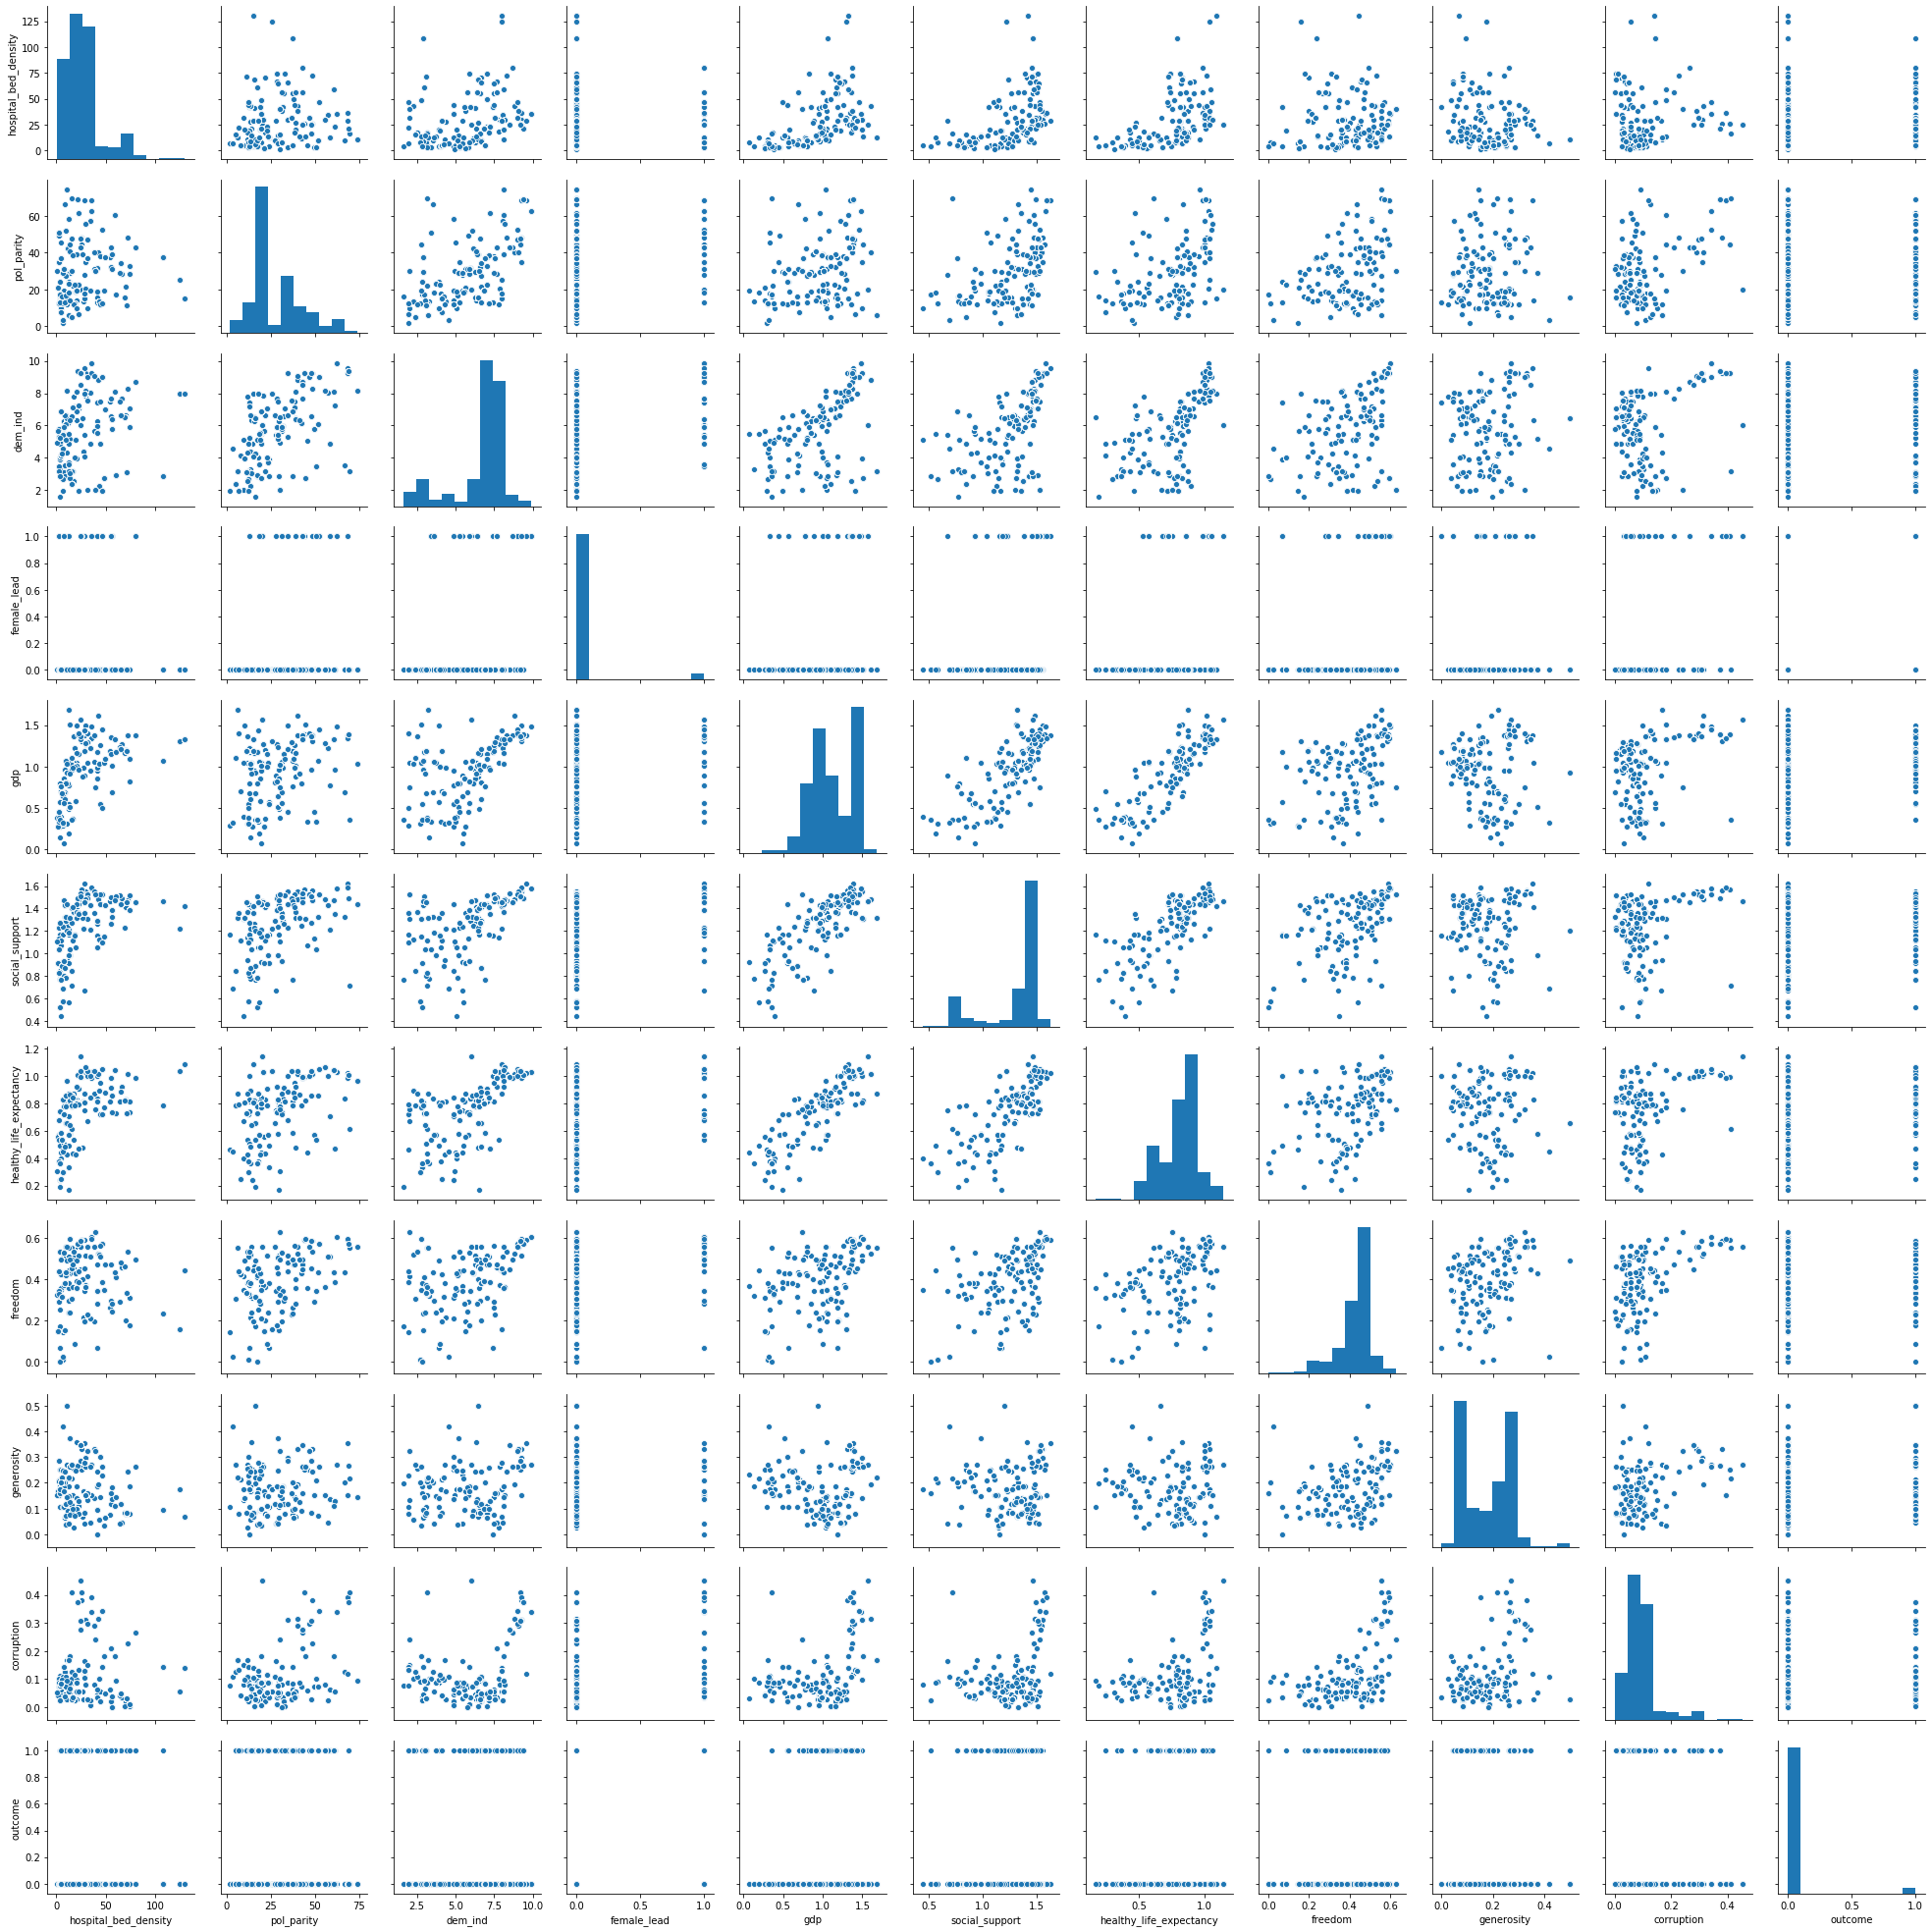

In [ ]:
df_sample = df1.sample(frac=0.05)
# Pairwise plots
pplot = sns.pairplot(df_sample)

In [ ]:
X.pol_parity.unique()

array([42.6, 47.7, 42.9, 55.8, 37. , 68.7, 39. , 17.6, 19.3, 60.4, 51.9,
       22.8, 34.6, 47. , 40.9, 58.3, 38.6, 19.1, 31.5, 31.3, 47.8,  4.8,
       12.1, 52.4, 40.3, 61.4, 57.1, 28.9, 15.7, 23.2, 19.5, 12.8, 30. ,
       37.7,  9.8, 43.1, 11.8, 11.3, 44.2,  6.5, 42.5, 48.4, 53.6, 20.4,
       15.3, 32.9, 17.4,  6.2, 37.5, 38.3, 21.7, 68.3, 74.2, 14. , 34.5,
       62.4, 29.9, 28.5, 32.3, 44.5, 28.4, 37.1, 17.5, 24. , 28.8, 16.4,
       68.2, 27.5, 18.2, 15.9, 30.9,  9.6, 13. , 66.5, 12.5, 18.1, 29.3,
        3.6, 17. , 17.7, 37.3, 24.1, 49.4, 19. , 39.1, 13.6, 11.5, 29.5,
       12.6, 29.7, 29. , 14.3, 22. , 15.1, 19.7, 13.2, 12.3, 30.1, 21.1,
       25.4, 25. ,  7.8, 16.2, 19.8, 33.7, 50.8, 27.7, 48.3, 12.7, 13.4,
       13.5, 17.9, 11.9, 21.2, 69.6, 51.2, 30.6, 45.4, 27.4,  1.9,  9.3])

In [ ]:
X

,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption
0,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210
1,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210
2,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210
3,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210
4,55.8,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210
...,...,...,...,...,...,...,...,...,...,...
212671,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212672,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212673,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212674,11.0,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167


In [ ]:
dfa = dfaa

In [ ]:
dfa.drop(['outcome'], axis = 1, inplace = True)

KeyError: "['outcome'] not found in axis"

In [ ]:
dfa

,Unnamed: 0,country,cases,deaths,mortality_rate,recovered,hospital_bed_density,pol_parity,dem_ind,female_lead,gdp,social_support,healthy_life_expectancy,freedom,generosity,corruption
0,0,Belgium,77869.0,9935.0,0.128,67934.0,55.80,42.6,7.64,1.0,1.356,1.504,0.986,0.473,0.160,0.210
1,1,Peru,516296.0,25856.0,0.050,490440.0,15.91,47.7,6.60,0.0,0.960,1.274,0.854,0.455,0.083,0.027
2,2,United Kingdom,319232.0,46791.0,0.147,272441.0,24.60,42.9,8.52,0.0,1.333,1.538,0.996,0.450,0.348,0.278
3,3,Spain,342813.0,28617.0,0.083,314196.0,29.70,55.8,8.18,0.0,1.286,1.484,1.062,0.362,0.153,0.079
4,4,Italy,253438.0,35392.0,0.140,218046.0,31.40,37.0,7.52,0.0,1.294,1.488,1.039,0.231,0.158,0.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212810,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212811,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212812,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167
212813,138,Gambia,1689.0,54.0,0.032,1635.0,11.00,11.9,4.33,0.0,0.308,0.939,0.428,0.382,0.269,0.167


In [ ]:
import sklearn
print(sklearn.__version__)

0.20.1
